
There are 2 stages to this experiment. First is to bucket the dataset and second is to train based on entropy score. 
Bucketing the dataset involves the following:
1. using ``google-bert/bert-base-uncased``, we will tokenize the text.
2. On default, ``bert-base-uncased`` creates embeddings that are in 768 dimensions.
3. Embeddings are then reduced in size to around 50.
4. Extract n amount from each bucket to create the first training stage dataset.

Training based on entropy score involves the following:
1. Remove the previously trained data from the dataset pool.
2. Predict on the rest of the dataset pool using the previously trained data in stage 1.
3. Convert prediction scores to entropy
4. Sort by highest entropy, seperate into buckets again.
5. Extract m amount from each bucket to create the second training stage dataset.
  
Entropy based training can be done multiple times until sufficient.

For each stage, we can compare it to a model trained on a randomly selected amount of data from the dataset pool. 

Since we are trying to prove that it is possible to create a high quality model without a huge amount of data, for each comparison, we can select the same amount of data used to train the bucketing model up to that point.

# Load and preprocess dataset
We are trying to prove that bucketing and entropy based training can reduce the amount of data needed to reduce a well balanced model. This is a case of one-shot model training. To reduce external factors such as bad data quality, etc; we will be utilizing StanfordNLP's SST2 dataset which  is a standard NLP benchmark for sentiment classification. The dataset will be loaded from huggingface via ``stanfordnlp/sst2``

In [1]:
from datasets import load_dataset
ds = load_dataset("mteb/amazon_polarity", cache_dir="caches/")

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's split into 3 variables

In [2]:
train_ds = ds["train"]
test_ds = ds["test"]

In [3]:
test_ds

Dataset({
    features: ['label', 'text', 'label_text'],
    num_rows: 400000
})

Perform very light cleaning on the dataset

In [4]:
import re
def clean_text(row):
    text = row["text"]
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove non-printable characters
    text = re.sub(r"[\x00-\x1F\x7F]", " ", text)
    # Replace multiple spaces/newlines with single space
    text = re.sub(r"\s+", " ", text)
    # Optionally lowercase
    text = text.strip()  # Don't lowercase if case matters
    return {
        "text": text
    }

4 million rows is a little too much so lets cut it back to around 10000

In [5]:
train_valid = train_ds.train_test_split(test_size=0.01, seed=42)
test_valid = test_ds.train_test_split(test_size=0.01, seed=42)

train_ds_reduced = train_valid["test"]
test_ds_reduced = test_valid["test"]

train_ds_reduced = train_ds_reduced.map(clean_text)
test_ds_reduced = test_ds_reduced.map(clean_text)

print(f"Train DS length: {len(train_ds_reduced)}")
print(f"Test DS length: {len(test_ds_reduced)}")

Train DS length: 36000
Test DS length: 4000


# Generate embeddings
As mentioned before, embeddings are generated using ```google-bert/bert-base-uncased``` model. 

Define the tokenizer function

In [6]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = AutoModel.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")
model.to(device)
model.eval()



BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [7]:
import torch
def get_mean_pooled_embeddings(batch):
  inputs = tokenizer(
    batch["text"],
    truncation=True,
    padding="max_length",
    return_tensors="pt"
  )
  inputs = {k: v.to(device) for k, v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden = outputs.last_hidden_state
  mask = inputs["attention_mask"].unsqueeze(-1)
  mean_pool = (last_hidden * mask).sum(dim = 1) / mask.sum(dim = 1)
  return {
    "mean_pooled_embeddings": mean_pool.cpu().numpy()
  }
  

In [8]:
train_ds_reduced = train_ds_reduced.map(get_mean_pooled_embeddings, batch_size=8, batched=True)

In [9]:
import numpy as np
np.save("bert_mean_pooled_embeddings.npy", train_ds_reduced["mean_pooled_embeddings"])

In [10]:
import numpy as np
mean_pooled_bert_embeddings = np.load("bert_mean_pooled_embeddings.npy")

# Create clusters

So i tried a few different experiments where i either:
1. reduce 768 dimensions to 50
2. reduce 768 dimensiosn to 2
3. reduce 768 dimensions to 50 to 50
4. reduce 768 dimensions to 50 to 2
5. reduce 768 dimensions to 2 to 2


Lets compare the scores

In [11]:
from umap import UMAP
from sklearn.preprocessing import RobustScaler
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

scaler = RobustScaler()
label_umap = UMAP(n_components=50, random_state=42)
visual_umap = UMAP(n_components=2, random_state=42)
clusterer = HDBSCAN(min_cluster_size=200)

In [12]:

# 768 -> 50

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
# label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

# 768 -> 2

label_embeddings = visual_umap.fit_transform(mean_pooled_bert_embeddings)
# label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")


# 768 -> 50 -> 50

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = label_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

# 768 -> 50 -> 2

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

# 768 -> 2 -> 2

label_embeddings = visual_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusters=5 | Silhouette: 0.3904 | Davies-Bouldin: 0.6881 | Calinski-Harabasz: 17599.1213


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusters=4 | Silhouette: 0.3050 | Davies-Bouldin: 0.7016 | Calinski-Harabasz: 30961.4774


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusters=6 | Silhouette: 0.1168 | Davies-Bouldin: 1.9321 | Calinski-Harabasz: 2508.4634


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusters=6 | Silhouette: 0.4985 | Davies-Bouldin: 0.4379 | Calinski-Harabasz: 46186.0967


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


clusters=2 | Silhouette: 0.2971 | Davies-Bouldin: 1.1405 | Calinski-Harabasz: 14280.8449


Based on the results itself, I discovered quite a surprising result where an unorthodox feature of reducing BERT embeddings of 768 to 50 then 2 before passing it through the HDBSCAN clustering algorithm yielded the best results of all. It is very much unorthodox and contrary to popular beliefs. But since the scores are significantly better, we will be proceeding with this in the next steps/

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


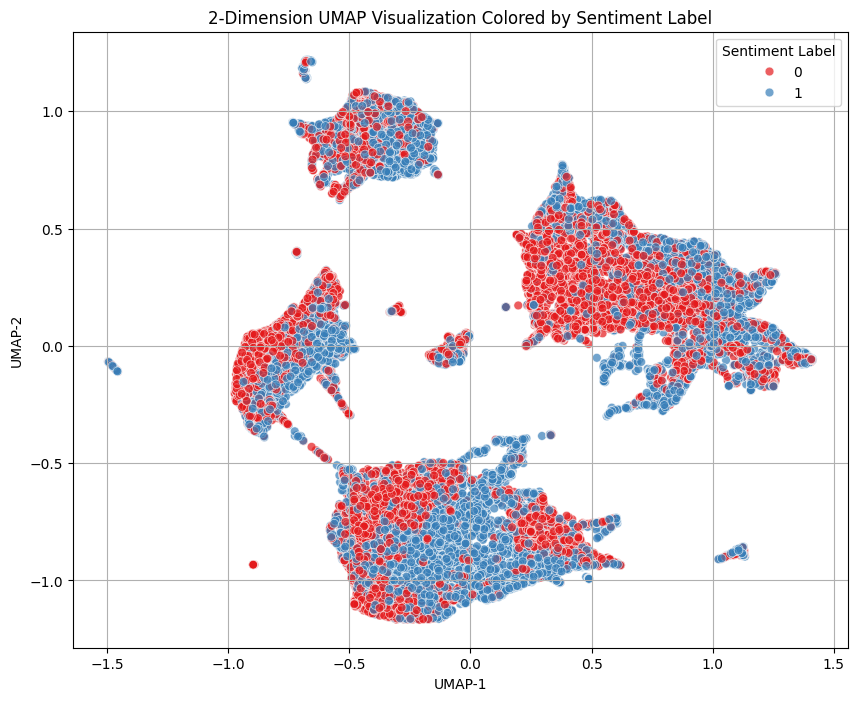

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
label_umap = UMAP(n_components=50, random_state=42)
visual_umap = UMAP(n_components=2, random_state=42)

X_umap = label_umap.fit_transform(mean_pooled_bert_embeddings)
X_umap = visual_umap.fit_transform(X_umap)
X_umap = scaler.fit_transform(X_umap)

y_true = train_ds_reduced["label"]

plt.figure(figsize=(10, 8))
palette = sns.color_palette("Set1", n_colors=len(set(y_true)))  # distinct colors for each label
sns.scatterplot(x= X_umap[:, 0], y=X_umap[:, 1], hue=y_true, palette=palette, alpha=0.7, s=40)
plt.title('2-Dimension UMAP Visualization Colored by Sentiment Label')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Sentiment Label')
plt.grid(True)
plt.show()

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings

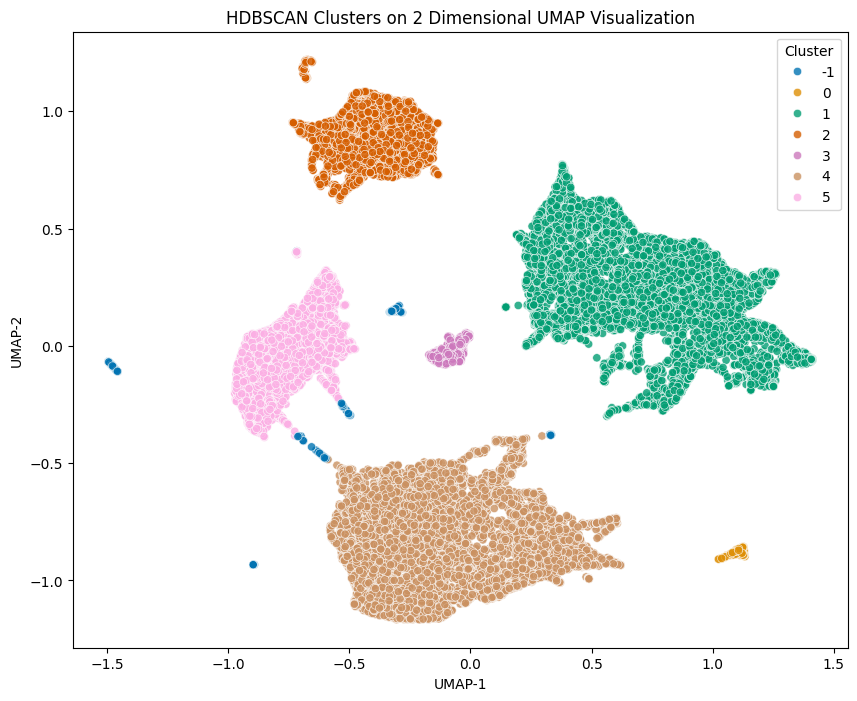

clusters=6 | Silhouette: 0.4985 | Davies-Bouldin: 0.4379 | Calinski-Harabasz: 46186.0967


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import RobustScaler
from hdbscan import HDBSCAN

scaler = RobustScaler()
label_umap = UMAP(n_components=50, random_state=42)
visual_umap = UMAP(n_components=2, random_state=42)
# This section is purely to alter the embedding dimensions to produce the labels
clusterer = HDBSCAN(min_cluster_size=200)

label_embeddings = label_umap.fit_transform(mean_pooled_bert_embeddings)
label_embeddings = visual_umap.fit_transform(label_embeddings)
# label_embeddings = visual_umap.fit_transform(label_embeddings)
label_embeddings = scaler.fit_transform(label_embeddings)

labels = clusterer.fit_predict(label_embeddings)

# This section is purely for visualization

X_umap = label_umap.fit_transform(mean_pooled_bert_embeddings)
X_umap = visual_umap.fit_transform(X_umap)
X_umap = scaler.fit_transform(X_umap)

# 3. Plot t-SNE results colored by HDBSCAN cluster labels
plt.figure(figsize=(10, 8))
palette = sns.color_palette("colorblind", n_colors=len(set(labels)))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette=palette, legend='full', alpha=0.8)

plt.title("HDBSCAN Clusters on 2 Dimensional UMAP Visualization")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster')
plt.show()

mask = labels != -1
filtered_embeddings = label_embeddings[mask]
filtered_labels = labels[mask]

if len(np.unique(filtered_labels)) > 1:  # At least 2 clusters needed for metrics
    sil_score = silhouette_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    n_clusters = len(np.unique(filtered_labels))
else:
    sil_score = db_score = ch_score = np.nan
    n_clusters = len(np.unique(filtered_labels))

print(f"clusters={n_clusters} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.4f}")



# Building a dataset for model training

Using the results of the previous experiment, let's redefine some program variables

In [32]:
from umap import UMAP
from sklearn.preprocessing import RobustScaler
from hdbscan import HDBSCAN
from datasets import  concatenate_datasets
import numpy as np

scaler = RobustScaler()
umap_50 =  UMAP(n_components=50, random_state=42)
umap_2 = UMAP(n_components=2, random_state=42)
clusterer = HDBSCAN(min_cluster_size=200)


# Reduce and scale the embeddings

reduced_embedding = umap_50.fit_transform(mean_pooled_bert_embeddings)
reduced_embedding = umap_2.fit_transform(reduced_embedding)
reduced_embedding = scaler.fit_transform(reduced_embedding)


# Cluster the embeddings
labels = clusterer.fit_predict(reduced_embedding)
labels = np.array(labels)
unique_labels = np.unique(labels)
# Apply the labels on the training dataset

train_ds_reduced = train_ds_reduced.add_column("bucket", labels)

grouped_datasets = [
  train_ds_reduced.select(indices) for label in unique_labels for indices in [np.where(labels == label)[0]]
]


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings

Sample n amount from each bucket to create a dataset

In [35]:
import math
TOTAL_DATA = 1000

TOTAL_CLEANED_DATA = 1000

NON_NOISE_LABEL = len(unique_labels) - 1

AMOUNT_PER_BUCKET = math.ceil(TOTAL_CLEANED_DATA / NON_NOISE_LABEL)

k = 100  # samples to take from each of the remaining datasets

# Take all rows from the first dataset
merged = []

# Sample k rows from the rest
for ds in grouped_datasets[1:]:
  sample = ds.shuffle(seed=42).select(range(min(AMOUNT_PER_BUCKET, len(ds))))
  merged.append(sample)

# Combine into a single dataset
final_dataset = concatenate_datasets(merged)

In [36]:
for ds in grouped_datasets:
    print(f"Dataset with label {ds.features['label']} has {len(ds)} samples.")
    
len(final_dataset)

Dataset with label Value(dtype='int64', id=None) has 249 samples.
Dataset with label Value(dtype='int64', id=None) has 246 samples.
Dataset with label Value(dtype='int64', id=None) has 13444 samples.
Dataset with label Value(dtype='int64', id=None) has 4767 samples.
Dataset with label Value(dtype='int64', id=None) has 699 samples.
Dataset with label Value(dtype='int64', id=None) has 11751 samples.
Dataset with label Value(dtype='int64', id=None) has 4844 samples.


1002

# Train the model on the bucketed data

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="caches/")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
def get_tokens(batch):
  tokens =  tokenizer(
    batch["text"],
    truncation=True,
    padding="max_length",
    return_tensors="pt",
    max_length=256
  )
  return tokens

In [37]:
final_dataset

Dataset({
    features: ['label', 'text', 'label_text', 'mean_pooled_embeddings', 'bucket'],
    num_rows: 1002
})

In [21]:
tokenized_dataset = final_dataset.map(get_tokens, batch_size=16, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Map: 100%|██████████| 1002/1002 [00:00<00:00, 5464.89 examples/s]


In [22]:
len(tokenized_dataset["input_ids"][0])

256

In [23]:
final_dataset_split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

final_dataset_train = final_dataset_split["train"]
final_dataset_test = final_dataset_split["test"]

In [24]:
from torch.utils.data import DataLoader
from transformers import default_data_collator
dl = DataLoader(tokenized_dataset, batch_size=4, collate_fn=default_data_collator)

for batch in dl:
    print(batch['input_ids'].shape)  # ❌ Likely to crash or be malformed
    break

torch.Size([4, 256])


In [25]:
from gc import callbacks
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./results",
  num_train_epochs=10,
  per_device_train_batch_size=8,
  save_strategy="epoch",
  logging_strategy="steps",
  logging_steps=50,
  load_best_model_at_end=True,
  metric_for_best_model="eval_precision",
  greater_is_better=True,
  eval_strategy="epoch",
  warmup_ratio=0.1,
  weight_decay=0.01,
  learning_rate=3e-5,
  lr_scheduler_type="linear",
)

In [26]:
from transformers import Trainer, default_data_collator
from torch.optim import AdamW
import evaluate
import numpy as np
from transformers import EarlyStoppingCallback, Trainer
accuracy_metric = evaluate.load("accuracy")
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1, zero_division=0
    )

    acc = accuracy_score(labels, preds)

    return {
        "eval_accuracy": acc,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1,
    }
  
trainer = Trainer(
  model=model,
  args = training_args,
  train_dataset=final_dataset_train,
  eval_dataset=final_dataset_test,
  compute_metrics=compute_metrics,
  data_collator=default_data_collator,
  optimizers=(AdamW(model.parameters(), lr=5e-5), None),
  callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)]
)

In [27]:
trainer.train()

/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.323300,0.341146,0.861386,0.816667,0.942308,0.875000
2,0.258000,0.378608,0.930693,0.924528,0.942308,0.933333
3,0.101200,0.481152,0.900990,0.937500,0.865385,0.900000
4,0.025700,0.687747,0.881188,0.833333,0.961538,0.892857
5,0.028600,0.541831,0.900990,0.903846,0.903846,0.903846


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=565, training_loss=0.17743038229265176, metrics={'train_runtime': 457.5727, 'train_samples_per_second': 19.691, 'train_steps_per_second': 2.47, 'total_flos': 592657652198400.0, 'train_loss': 0.17743038229265176, 'epoch': 5.0})

Evaluate the initially trained model on 1000 bucketed data

In [28]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)
from transformers import Trainer

CLASS_NAMES = ["negative", "positive"]  # adjust if you have more

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    # overall (macro) metrics
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)

    # per-class metrics
    per_class = precision_recall_fscore_support(labels, preds, average=None, zero_division=0)
    p_cls, r_cls, f1_cls, support_cls = per_class

    # Flatten per-class metrics into scalars in the returned dict
    metrics = {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
    }
    for idx, name in enumerate(CLASS_NAMES):
        metrics[f"{name}_precision"] = p_cls[idx]
        metrics[f"{name}_recall"]    = r_cls[idx]
        metrics[f"{name}_f1"]        = f1_cls[idx]
        metrics[f"{name}_support"]   = support_cls[idx]

    return metrics
test_ds_reduced = test_ds_reduced.map(get_tokens, batch_size=16, batched=True)
if "labels" not in test_ds_reduced.column_names:
    test_ds_reduced = test_ds_reduced.rename_column("label", "labels")

evaluation_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_ds_reduced,
    data_collator=default_data_collator,
    optimizers=(AdamW(model.parameters(), lr=5e-5), None),
    compute_metrics=compute_metrics,
)
metrics = evaluation_trainer.evaluate()
pred_out = evaluation_trainer.predict(test_ds_reduced)

logits = torch.tensor(pred_out.predictions, dtype=torch.float32)
probs = torch.nn.functional.softmax(logits, dim=1) 
preds  = pred_out.predictions.argmax(axis=1)
labels = pred_out.label_ids



print("\n=== Confusion Matrix ===")
print(confusion_matrix(labels, preds))

print("\n=== Classification Report ===")
print(classification_report(labels, preds, target_names=CLASS_NAMES, digits=4))

print("=== Scalar metrics returned by Trainer ===")
for k, v in metrics.items():
    print(f"{k:20s}: {v:.4f}")

Map: 100%|██████████| 4000/4000 [00:00<00:00, 5764.29 examples/s]
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Confusion Matrix ===
[[1889   73]
 [ 359 1679]]

=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.8403    0.9628    0.8974      1962
    positive     0.9583    0.8238    0.8860      2038

    accuracy                         0.8920      4000
   macro avg     0.8993    0.8933    0.8917      4000
weighted avg     0.9004    0.8920    0.8916      4000

=== Scalar metrics returned by Trainer ===
eval_loss           : 0.5794
eval_model_preparation_time: 0.0013
eval_accuracy       : 0.8920
eval_macro_f1       : 0.8917
eval_macro_precision: 0.8993
eval_macro_recall   : 0.8933
eval_negative_precision: 0.8403
eval_negative_recall: 0.9628
eval_negative_f1    : 0.8974
eval_negative_support: 1962.0000
eval_positive_precision: 0.9583
eval_positive_recall: 0.8238
eval_positive_f1    : 0.8860
eval_positive_support: 2038.0000
eval_runtime        : 96.7621
eval_samples_per_second: 41.3380
eval_steps_per_second: 5.1670


In [29]:
model.save_pretrained("save/model/amazon_polarity_model_bucketing")
tokenizer.save_pretrained("save/tokenizer/amazon_polarity_tokenizer_bucketing")
print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


Filter out used data contained within ```final_dataset``` from ```train_ds_reduced```

In [38]:
from datasets import Dataset
import json

# Make row identifiers from dataset_b
dataset_b_keys = set(json.dumps(row, sort_keys=True) for row in final_dataset)

# Filter out matching rows from dataset_a
filtered_dataset = train_ds_reduced.filter(
    lambda row: json.dumps(row, sort_keys=True) not in dataset_b_keys
)

Filter: 100%|██████████| 36000/36000 [00:14<00:00, 2561.01 examples/s]


In [43]:
print(len(final_dataset))
print(len(train_ds_reduced))

print(f"expected: {abs(len(final_dataset) - len(train_ds_reduced))}")
print(len(filtered_dataset))

1002
36000
expected: 34998
34998


# Run predictions on the training dataset to obtain the prediction score

Load the previously trained model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("save/model/amazon_polarity_model_bucketing", cache_dir="caches/", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("save/tokenizer/amazon_polarity_tokenizer_bucketing", cache_dir="caches/")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

define the prediction func

In [51]:
from tqdm import tqdm
import torch.nn.functional as F
from scipy.stats import entropy as scipy_entropy
import torch
def predict(batch):
  results = []
  inputs = tokenizer(
      batch["text"],
      truncation=True,
      padding="max_length",
      return_tensors="pt",
      max_length=256
  )
  inputs = {k: v.to(device) for k, v in inputs.items()}
  with torch.no_grad():
    outputs = model(**inputs)
  logits = outputs.logits
  probs = torch.softmax(logits, dim=1)
  indices = torch.argmax(probs, dim=1)
  label_map = {0: "negative", 1: "positive"}
  results = [label_map[idx.item()] for idx in indices]
  
  probs_np = probs.cpu().numpy()
  entropies = [scipy_entropy(probs, base=2) for probs in probs_np]
  
  
  return {
    "predicted_label": results,
    "predicted_entropy": entropies,
    "predicted_probs": probs_np.tolist()
  }

In [52]:
filtered_dataset = filtered_dataset.map(predict, batch_size=16, batched=True)

Map: 100%|██████████| 34998/34998 [13:47<00:00, 42.29 examples/s]


In [ ]:
if "mean_pooled_embeddings" in filtered_dataset.column_names:
    filtered_dataset = filtered_dataset.remove_columns("mean_pooled_embeddings")

In [59]:
filtered_dataset

Dataset({
    features: ['label', 'label_text', 'bucket', 'predicted_label', 'predicted_entropy', 'predicted_probs'],
    num_rows: 34998
})